This notebook demonstrates use of our linear approximation for a multiplicative functional perturbation 

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp

from numpy.polynomial.hermite import hermgauss

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
from bnpgmm_runjingdev import utils_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib 
from bnpmodeling_runjingdev import cluster_quantities_lib as cluster_lib


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles
from tqdm import tqdm

import json 

/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

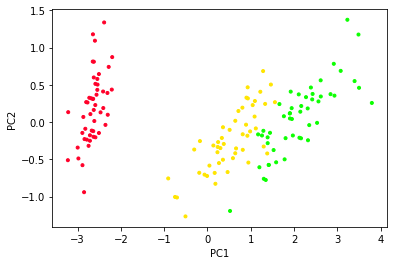

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

### Get prior 

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [6]:
print(prior_params_dict)

{'alpha': DeviceArray([3.], dtype=float64), 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


In [7]:
# DP prior parameter 
prior_params_dict['alpha'] = 3.5

### Variational parameters

In [8]:
k_approx = 30

In [9]:
# Gauss-Hermite points
gh_deg = 20
gh_loc, gh_weights = hermgauss(gh_deg)


In [10]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [11]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(1639.26326172, dtype=float64)

# Optimize

### Kmeans

In [12]:
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 2391)
                                                # seed = 32423)

### Run CAVI

In [13]:
vb_params_dict = deepcopy(init_vb_params_dict)

In [14]:
vb_opt_dict, e_z_opt = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                            x_tol = 1e-3)

Compiling CAVI update functions ... 
CAVI compile time: 3.44sec

Running CAVI ... 
done. num iterations = 87
stick_time: 0.749sec
cluster_time: 0.566sec
e_z_time: 0.0169sec
**CAVI time: 1.44sec**


In [15]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [16]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


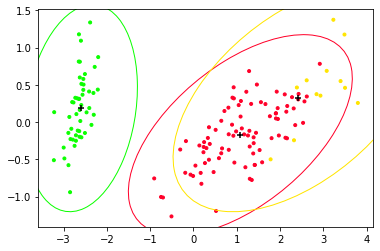

In [17]:
# results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)

# Define a perturbation in the logit v space.

In [18]:
def log_phi(logit_v):
    return(sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


In [19]:
logit_v_grid = np.linspace(-8, 8, 200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

def rescaled_log_phi(logit_v):
    return 5 * log_phi(logit_v) 

In [20]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['alpha'],
                                log_phi = rescaled_log_phi, 
                                logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-1.2527629265819875 1.6117424303835712 -1.253936900542948 1.6126820457161757


Text(0.5, 1.0, 'Priors in logit space')

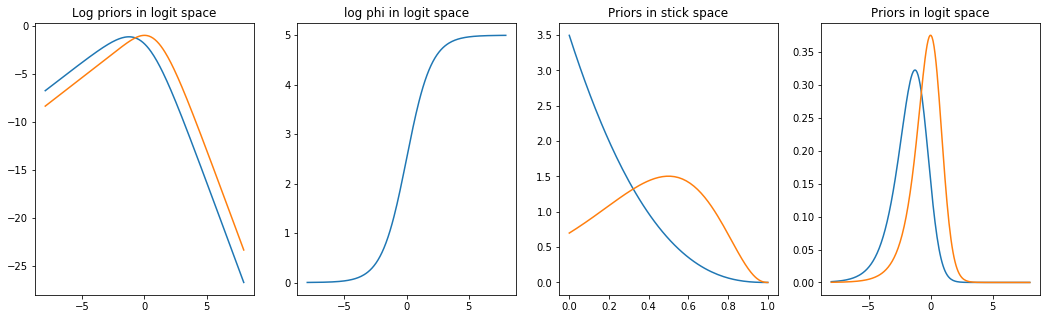

In [21]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [22]:
log_prior_pert = lambda logit_v : rescaled_log_phi(logit_v) - prior_perturbation.log_norm_pc_logit

In [23]:
e_log_prior_pert = lambda means, info, epsilon : \
                        func_sens_lib.get_e_log_perturbation(log_prior_pert,
                            means, info, epsilon, 
                            gh_loc, gh_weights, sum_vector=True)

# Define prior perturbation

In [2]:
# the KL objective
def _get_epsilon_vb_loss(params, epsilon): 
    kl = gmm_lib.get_kl(features, 
                    params,
                    prior_params_dict, 
                    gh_loc, gh_weights) 
    
    perturbation = e_log_prior_pert(params['stick_params']['stick_propn_mean'],
                                    params['stick_params']['stick_propn_info'], 
                                    epsilon)
    
    return kl - perturbation

get_epsilon_vb_loss = paragami.FlattenFunctionInput(_get_epsilon_vb_loss, 
                                                    argnums=0, 
                                                    patterns=vb_params_paragami,
                                                    free=True)


NameError: name 'paragami' is not defined

In [25]:
# the terms of the KL objective that depend on epsilon 
def _hyper_par_objective_fun(params, epsilon): 
    return -e_log_prior_pert(params['stick_params']['stick_propn_mean'],
                            params['stick_params']['stick_propn_info'], 
                            epsilon)


hyper_par_objective_fun = paragami.FlattenFunctionInput(_hyper_par_objective_fun,
                                                        argnums=0, 
                                                        patterns=vb_params_paragami,
                                                        free=True)

In [26]:
epsilon0 = np.array([0.])

In [27]:
epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        objective_fun = get_epsilon_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        hyper_par_objective_fun = hyper_par_objective_fun, 
        )

Compiling hessian solver ...
Hessian solver compile time: 41.8691sec

Compiling cross hessian...
Cross-hessian compile time: 0.332884sec

LR sensitivity time: 0.0575497sec



In [28]:
# compute LR derivative 

In [29]:
epsilon = 1.0 
print('Epsilon: ', epsilon)

vb_pert_pred = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))

Epsilon:  1.0
Predicted differences:  5.337335784216399


In [30]:
vb_pert_pred_dict = vb_params_paragami.fold(vb_pert_pred, free = True)
e_z_pert_pred = gmm_lib.get_optimal_z_from_vb_params_dict(
    features, vb_pert_pred_dict, gh_loc, gh_weights)

# Fit with perturbation

In [31]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [32]:
vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_dict,
                                        gh_loc, gh_weights,
                                        e_log_phi = lambda means, info : \
                                                       e_log_prior_pert(means, info, epsilon), 
                                        debug = False)

vb_pert_opt = vb_params_paragami.flatten(vb_pert_dict, free = True)

Compiling CAVI update functions ... 
CAVI compile time: 2.83sec

Running CAVI ... 
done. num iterations = 72
stick_time: 0.578sec
cluster_time: 0.0275sec
e_z_time: 0.0148sec
**CAVI time: 0.66sec**


In [33]:
vb_pert_opt_dict = vb_params_paragami.fold(vb_pert_opt, free = True)
e_z_pert_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_pert_opt_dict, gh_loc, gh_weights)

Epsilon: 1.0


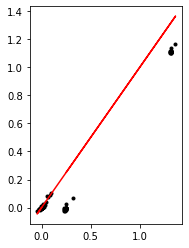

In [34]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vb_pert_opt - vb_opt, vb_pert_pred - vb_opt, 'k.')
plt.plot(vb_pert_opt - vb_opt, vb_pert_opt - vb_opt, 'r')


In [35]:
print('original expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_opt_dict['stick_params']['stick_propn_mean'], 
                                                        1 / np.sqrt(vb_opt_dict['stick_params']['stick_propn_info']), 
                                                        n_obs = 150, 
                                                        n_samples = 10000, 
                                                        rng_key = jax.random.PRNGKey(1)))

print('perturbed expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_opt_dict['stick_params']['stick_propn_mean'], 
                                                        1 / np.sqrt(vb_pert_opt_dict['stick_params']['stick_propn_info']), 
                                                        n_obs = 150, 
                                                        n_samples = 10000, 
                                                        rng_key = jax.random.PRNGKey(1)))

print('predicted expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_pred_dict['stick_params']['stick_propn_mean'], 
                                                        1 / np.sqrt(vb_pert_pred_dict['stick_params']['stick_propn_info']), 
                                                        n_obs = 150, 
                                                        n_samples = 10000, 
                                                        rng_key = jax.random.PRNGKey(1)))


      

original expected number of clusters:  6.749641951478156
perturbed expected number of clusters:  5.885044004930613
predicted expected number of clusters:  5.970912026530918


# Predict for a range of perturbations

In [36]:
# The range of epsilons we shall consider
epsilon_vec = np.linspace(0, 1, 12) ** 2 # Square to get more points close to 0
print(epsilon_vec)

[0.         0.00826446 0.03305785 0.07438017 0.1322314  0.20661157
 0.29752066 0.40495868 0.52892562 0.66942149 0.82644628 1.        ]


In [37]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum

    vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_dict,
                                        gh_loc, gh_weights,
                                        e_log_phi = lambda means, info : \
                                                       e_log_prior_pert(means, info, epsilon), 
                                       debug = False)
    
    return vb_params_paragami.flatten(vb_pert_dict, free = True)

In [38]:
best_param_phi_array = []
best_param_phi_pred_array = []

In [39]:
vb_pert_opt_array = []
vb_pert_pred_array = []


for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    vb_pert_pred = \
        epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    
    # Then fit with the perturbation.
    vb_pert_opt = refit_with_epsilon(epsilon, new_init_dict)
    
    print('Done. ')

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    print('Actual differences:',
          np.linalg.norm(vb_pert_opt - vb_opt))
    
    # save results: 
    vb_pert_opt_array.append(vb_pert_opt)
    vb_pert_pred_array.append(vb_pert_pred)
    




Epsilon:  0.0
Predicted differences:  0.0
Compiling CAVI update functions ... 
CAVI compile time: 3.01sec

Running CAVI ... 
done. num iterations = 2
stick_time: 0.0223sec
cluster_time: 0.00101sec
e_z_time: 0.000889sec
**CAVI time: 0.0261sec**
Done. 
Predicted differences:  0.0
Actual differences: 0.01120586757009614


Epsilon:  0.008264462809917356
Predicted differences:  0.04411021309269751
Compiling CAVI update functions ... 
CAVI compile time: 2.71sec

Running CAVI ... 
done. num iterations = 8
stick_time: 0.0673sec
cluster_time: 0.00311sec
e_z_time: 0.00196sec
**CAVI time: 0.0772sec**
Done. 
Predicted differences:  0.04411021309269751
Actual differences: 0.02908105336536518


Epsilon:  0.03305785123966942
Predicted differences:  0.17644085237079007
Compiling CAVI update functions ... 
CAVI compile time: 2.73sec

Running CAVI ... 
done. num iterations = 15
stick_time: 0.123sec
cluster_time: 0.00566sec
e_z_time: 0.00318sec
**CAVI time: 0.14sec**
Done. 
Predicted differences:  0.17

# Lets look at the expected number of clusters

### Number of in sample clusters

In [40]:
import numpy as onp

In [41]:
threshold = 0

lr_e_num_clusters_vec = onp.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(
        features, vb_params_paragami, 
        vb_pert_pred_array[i],
        gh_loc, gh_weights,
        threshold = threshold,
        n_samples = 10000, 
        rng_key = jax.random.PRNGKey(12))
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(
        features, vb_params_paragami, 
        vb_pert_opt_array[i],
        gh_loc, gh_weights,
        threshold = threshold,
        n_samples = 10000, 
        rng_key = jax.random.PRNGKey(12))
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


100%|██████████| 12/12 [00:20<00:00,  1.69s/it]


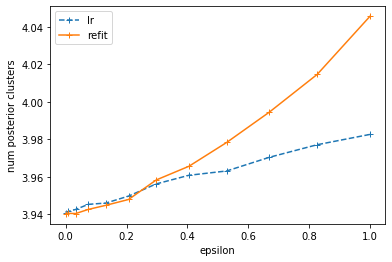

In [42]:
plt.plot(epsilon_vec, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))


### Number of predicted clusters

In [43]:
threshold = 0

lr_e_num_pred_clusters_vec = onp.zeros(len(epsilon_vec))
refit_e_num_pred_clusters_vec = onp.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(
        vb_params_paragami, 
        vb_pert_pred_array[i],
        n_obs = np.shape(features)[0], 
        threshold = threshold,
        n_samples = 10000, 
        rng_key = jax.random.PRNGKey(12))
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(
        vb_params_paragami, 
        vb_pert_opt_array[i],
        n_obs = np.shape(features)[0], 
        threshold = threshold,
        n_samples = 10000, 
        rng_key = jax.random.PRNGKey(12))
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


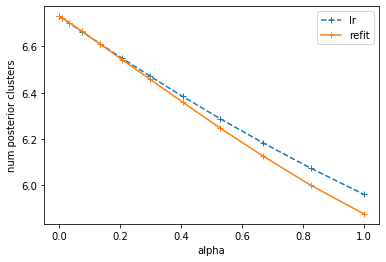

In [44]:
plt.plot(epsilon_vec, lr_e_num_pred_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))